# Reducing the number of H$\mathrm{_2}$O lines using pseudo-line generator (plg)
Tako Ishikawa  
last update: 2022/06/13   
created: : 2022/05/05　　

In [10]:
import os; os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
import numpy as np
import jax.numpy as jnp
from exojax.spec import plg
from exojax.spec import moldb, contdb, molinfo
from exojax.spec.rtransfer import nugrid
from exojax.spec import initspec
import matplotlib.pyplot as plt
import copy
#path_fig = '/home/tako/Dropbox/tmpfig/'

Set parameters used to make elower grid.

In [11]:
Nelower = 7 #number of division of elower grid 
Tgue = 3000. #rough guess on the typical atmospheric temperature of the object you analyze
errTgue = 500. #expected one-sided error of Tgue

Set a wavenumber grid using nugrid. 

In [12]:
wls, wll, nugrid_res = 15541, 15551, 0.05
nus, wav, reso = nugrid(wls, wll, int((wll-wls)/nugrid_res), unit="AA", xsmode="modit")

xsmode assumes ESLOG: mode= modit


Load a molecular database of H2O and CIA (H2-H2).

In [13]:
mdb_orig = moldb.MdbExomol('.database/H2O/1H2-16O/POKAZATEL/', nus, \
                           crit=0, Ttyp=Tgue) #1.e-40
mdb = copy.deepcopy(mdb_orig)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)
molmassH2O = molinfo.molmass("H2O")
print("Nline=", len(mdb_orig.A)) #chk

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  63  states
H2-H2
Nline= 1418720


Optimize the parameter "coefTgue" which is used to adjust the temperature referenced when creating the elower grid.

In [14]:
#To save computation time, let us use only the middle 1 Å width to optimize coefTgue here.
assess_width = 1. #Note that too narrow might cause a ValueError. (#Cause unspecified...)
nusc, wavc, resoc = nugrid( (wll+wls-assess_width)/2, (wll+wls+assess_width)/2, 20, unit="AA", xsmode="modit")
mdbc = moldb.MdbExomol('.database/H2O/1H2-16O/POKAZATEL/', nusc)

%time    coefTgue = plg.optimize_coefTgue(Tgue, nusc, mdbc, molmassH2O, Nelower, errTgue)
#coefTgue = plg.optimize_coefTgue(Tgue, nus, mdb_orig, molmassH2O, Nelower) #373.4 sec for 1418720 lines. :This is the case where we used the whole range.
print(len(mdbc.A), "lines,  coefTgue =", coefTgue)

xsmode assumes ESLOG: mode= modit
Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  10  J lower states in  61  states
CPU times: user 1min 6s, sys: 48.5 s, total: 1min 55s
Wall time: 1min 13s
141794 lines,  coefTgue = 0.8852231413848315


In [15]:
#test220613

'''
xsmode assumes ESLOG: mode= modit
WARNING: resolution may be too small. R= 295373.99989581696
Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  10  J lower states in  61  states
74.61414289474487 sec for 141794 lines,  coefTgue = 0.7144339106694811
1
'''

'\nxsmode assumes ESLOG: mode= modit\nWARNING: resolution may be too small. R= 295373.99989581696\nBackground atmosphere:  H2\nReading transition file\n.broad is used.\nBroadening code level= a1\ndefault broadening parameters are used for  10  J lower states in  61  states\n74.61414289474487 sec for 141794 lines,  coefTgue = 0.7144339106694811\n1\n'

Precompute the contribution for wavenumber.

In [16]:
cnu,indexnu,R,pmarray = initspec.init_modit(mdb.nu_lines,nus)
cnu_orig = copy.deepcopy(cnu)
indexnu_orig = copy.deepcopy(indexnu)

Make grids of parameters for Lorentzian width and an associated index.

In [17]:
alpha_ref_grid, n_Texp_grid, index_gamma = plg.make_gamma_grid_exomol(mdb)
Ngamma = len(alpha_ref_grid)

Generate pseudo lines by combining many weak lines in the same bin of the 3-d grid of elower, nu, and gamma.

In [18]:
%time    qlogsij0, qcnu, num_unique, elower_grid, frozen_mask, nonzeropl_mask = plg.plg_elower_addcon(\
    index_gamma, Ngamma, cnu, indexnu, nus, mdb, Tgue, errTgue, \
    Nelower=Nelower, Tmargin=0., coefTgue=coefTgue)    
print("elower_grid", elower_grid)

# of original lines: 1418720
# of unfrozen lines: 12344
# of frozen lines: 1406376
# of pseudo lines: 2208
# of total lines: 14552
# compression: 0.010257133190481561
CPU times: user 1.3 s, sys: 663 ms, total: 1.97 s
Wall time: 1.56 s
elower_grid [  487.13418579 34308.78807246 34466.45213042 34558.67969204
 34624.11618838 34674.87267819 34716.34375   ]


In [19]:
#test220613

'''
# of original lines: 1418720
# of unfrozen lines: 12344
# of frozen lines: 1406376
# of pseudo lines: 2208
# of total lines: 14552
# compression: 0.010257133190481561
1.7141990661621094 sec
elower_grid [  487.13418579 34298.23029271 34459.9786574  34554.5953853
 34621.7270221  34673.798365   34716.34375   ]
'''

'\n# of original lines: 1418720\n# of unfrozen lines: 12344\n# of frozen lines: 1406376\n# of pseudo lines: 2208\n# of total lines: 14552\n# compression: 0.010257133190481561\n1.7141990661621094 sec\nelower_grid [  487.13418579 34298.23029271 34459.9786574  34554.5953853\n 34621.7270221  34673.798365   34716.34375   ]\n'

Gather pseudo lines and unfrozen lines into a single molecular database (mdb).

In [20]:
mdb, cnu, indexnu = plg.gather_lines(mdb, Ngamma, len(nus), Nelower, nus, cnu, indexnu, qlogsij0, qcnu, elower_grid, alpha_ref_grid, n_Texp_grid, frozen_mask, nonzeropl_mask)

The pseudo-line generator is finished here.

## Try calculating spectra using the output mdb and compare it with the original.

Prepare for radiative transfer calculation.

In [21]:
from exojax.spec import rtransfer as rt
from exojax.spec import modit
from exojax.spec.modit import setdgm_exomol
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA
from exojax.spec import planck, response

#Assume atmosphere.
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
mmw=2.33 #mean molecular weight
mmrH2=0.74 #mass mixing ratio
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #volume mixing ratio
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)

#a core driver
def frun(Tarr,MMR_,Mp,Rp,u1,u2,RV,vsini):
    g=2478.57730044555*Mp/Rp**2
    SijM_,ngammaLM_,nsigmaDl_=modit.exomol(mdb,Tarr,Parr,R,molmassH2O)
    xsm_=modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl_,ngammaLM_,SijM_,nus,dgm_ngammaL)
    dtaum=dtauM(dParr,jnp.abs(xsm_),MMR_*ONEARR,molmassH2O,g) #abs is used to remove negative values in xsv
    #CIA
    dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
    dtau=dtaum+dtaucH2H2
    sourcef = planck.piBarr(Tarr,nus)
    F0=rtrun(dtau,sourcef)
    Frot=response.rigidrot(nus,F0,vsini,u1,u2)
    #mu=response.ipgauss_sampling(nusd,nus,Frot,beta_inst,RV)
    mu=Frot
    return mu

#Precompute gdm_ngammaL.
fT = lambda T0,alpha: T0[:,None]*(Parr[None,:]/Pref)**alpha[:,None]
T0_test=np.array([Tgue-300.,Tgue+300.,Tgue-300.,Tgue+300.])
alpha_test=np.array([0.2,0.2,0.05,0.05])
res=0.2
dgm_ngammaL=setdgm_exomol(mdb,fT,Parr,R,molmassH2O,res,T0_test,alpha_test)

#GPU Memory Usage ~ 841 MiB up to here.

Prepare the same for the original mdb before reducing the number of absorption lines.

In [22]:
#a core driver for original mdb
def frun_orig(Tarr, MMR_, Mp, Rp, u1, u2, RV, vsini):
    g = 2478.57730044555*Mp/Rp**2
    SijM_, ngammaLM_, nsigmaDl_ = modit.exomol(mdb_orig, Tarr, Parr, R, molmassH2O)
    xsm_ = modit.xsmatrix(cnu_orig, indexnu_orig, R, pmarray, nsigmaDl_, ngammaLM_, SijM_, nus, dgm_ngammaL_orig)
    dtaum = dtauM(dParr, jnp.abs(xsm_), MMR_*ONEARR, molmassH2O, g) #abs is used to remove negative values in xsv
    #CIA
    dtaucH2H2 = dtauCIA(nus, Tarr, Parr, dParr, vmrH2, vmrH2, mmw, g, cdbH2H2.nucia, cdbH2H2.tcia, cdbH2H2.logac)
    dtau = dtaum+dtaucH2H2
    sourcef  =  planck.piBarr(Tarr, nus)
    F0 = rtrun(dtau, sourcef)
    Frot = response.rigidrot(nus, F0, vsini, u1, u2)
    #mu = response.ipgauss_sampling(nusd, nus, Frot, beta_inst, RV)
    mu = Frot
    return mu

#Precompute gdm_ngammaL for original mdb.
dgm_ngammaL_orig = setdgm_exomol(mdb_orig, fT, Parr, R, molmassH2O, res, T0_test, alpha_test)

#GPU Memory Usage ~ 5695 MiB up to here.

Set stellar parameters.

In [23]:
#Example with GJ699 parameters (0.1863 R_sun, 0.155 M_sun from Mann+2015)
MpMd = 0.155 *1.99e33/1.90e30
RpMd = 0.186 *6.96e10/6.99e9  
MMR_rough = 0.001
plotTF = False

#Test with other parameters
#MpMd = 33.2; RpMd = 0.88; MMR_rough = 0.0059; plotTF=False
#MpMd = 41.; RpMd = 1.; MMR_rough = 0.001; plotTF=False

Calcuate and plot spectra.

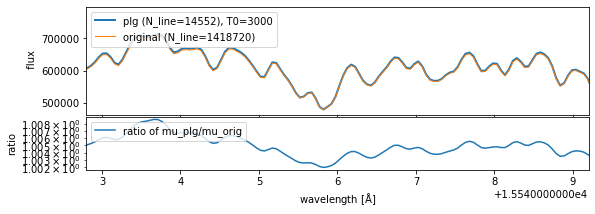

In [24]:
Tarr = Tgue*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

llow, lhigh, tip = 15543, 15549, 0.2

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + "h2oplg_tutorial.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()

## Additional check (Tshift)
Doesn't it matter if the actual temperatures deviate from Tgue?

2500.0


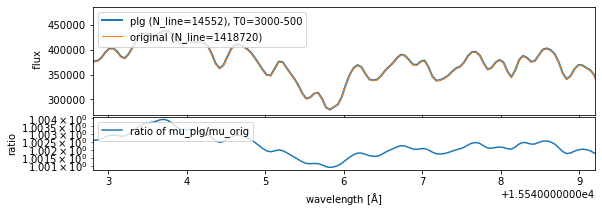

In [25]:
Tshift = -errTgue
print(Tgue + Tshift)

Tarr = (Tgue+Tshift)*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}{int(Tshift):+}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + f"h2oplg_tutorial_Tshift{int(Tshift):+}.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()

3500.0


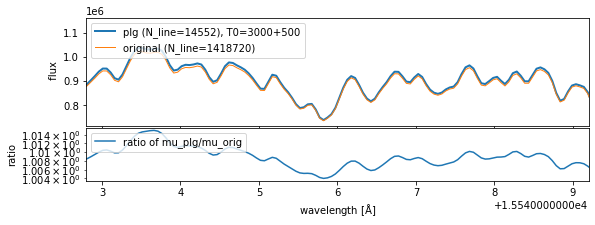

In [26]:
Tshift = +errTgue
print(Tgue + Tshift)

Tarr = (Tgue+Tshift)*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpMd, Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpMd,Rp=RpMd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}{int(Tshift):+}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + f"h2oplg_tutorial_Tshift{int(Tshift):+}.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()